# **Unveiling MITRE ATT&CK Techniques using Machine Learning Models for Command Classification**

## Data Pre-Processing

### Get malicious command yaml file from internet

In [1]:
import requests
import re

def get_files_name(repo_url, folder_path):
    api_url = f"{repo_url}/{folder_path}"
    response = requests.get(api_url)
    if folder_path == "":
      pattern = r'title="(.*?)" data-turbo-frame='
    else:
      pattern = r'(?<=title=")([^"]*\.yml)'

    matches = re.findall(pattern, response.text)
    return matches

In [2]:
repo_url = "https://github.com/trellix-enterprise/ac3-threat-sightings"
folder_path = "/tree/main/sightings"
ac3_files_name = get_files_name(repo_url, folder_path)

repo_url = "https://github.com/center-for-threat-informed-defense/adversary_emulation_library/"
folder_path = ""
AEL_apt_name = get_files_name(repo_url, folder_path)

In [3]:
# Atomic Red Team
!wget https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/Indexes/windows-index.yaml

# Adversary Emulation Library
for file_name in ac3_files_name:
  !wget -P ac3_command https://raw.githubusercontent.com/trellix-enterprise/ac3-threat-sightings/main/sightings/{file_name}

# AC3 Threat Sightings
for apt_name in AEL_apt_name:
  !wget -P ael_command https://raw.githubusercontent.com/center-for-threat-informed-defense/adversary_emulation_library/master/{apt_name}/Emulation_Plan/yaml/{apt_name.upper()}.yaml
  !wget -P ael_command https://raw.githubusercontent.com/center-for-threat-informed-defense/adversary_emulation_library/master/{apt_name}/Emulation_Plan/yaml/{apt_name.lower()}.yaml
  !wget -P ael_command https://raw.githubusercontent.com/center-for-threat-informed-defense/adversary_emulation_library/master/{apt_name}/Emulation_Plan/yaml/{apt_name.capitalize()}.yaml

--2023-06-16 18:36:55--  https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/Indexes/windows-index.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5892593 (5.6M) [text/plain]
Saving to: ‘windows-index.yaml.2’

windows-index.yaml. 100%[===================>]   5.62M  --.-KB/s    in 0.07s   

2023-06-16 18:36:55 (80.1 MB/s) - ‘windows-index.yaml.2’ saved [5892593/5892593]

--2023-06-16 18:36:55--  https://raw.githubusercontent.com/trellix-enterprise/ac3-threat-sightings/main/sightings/Sightings_BlackCat_Ransomware.yml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... con

### Extract userful data from yaml file
- 將 yaml 檔案中的指令、Tactics 抓出來並轉換成 dataframe 方便後續使用

In [4]:
import os
import yaml
import pandas as pd

In [5]:
df = pd.DataFrame()

In [6]:
cmd_line_dict = []

with open('windows-index.yaml', "r") as stream:
  atomic_data = yaml.load(stream, Loader=yaml.Loader)
  for tactic in atomic_data:
    for technique in atomic_data[tactic]:
      if 'atomic_tests' in atomic_data[tactic][technique]:
        for cmd_num in range(len(atomic_data[tactic][technique]['atomic_tests'])):
          if 'executor' in atomic_data[tactic][technique]['atomic_tests'][cmd_num]:
            if 'command' in atomic_data[tactic][technique]['atomic_tests'][cmd_num]['executor']:
              cmd_line = {tactic: atomic_data[tactic][technique]['atomic_tests'][cmd_num]['executor']['command']}
              cmd_line_dict.append(cmd_line)

for root, dirs, files in os.walk('ac3_command', topdown=False):
  for name in files:
    full_name = 'ac3_command/' + name
    with open(full_name, "r") as stream:
      ac3_data = yaml.load(stream, Loader=yaml.Loader)
      for sighting in ac3_data['threatSightings']:
        if 'behaviors' in sighting:
          behaviors = sighting['behaviors']
          for behavior in behaviors:
            if 'processes' in behavior and 'att&ck' in behavior:
              processes = behavior['processes']
              for process in processes:
                if 'cmdLine' in process:
                  cmdLine = process['cmdLine']
                  for cmd in cmdLine:
                    for tactic in behavior['att&ck']:
                      cmd_line = {tactic: cmd}
                      cmd_line_dict.append(cmd_line)

for root, dirs, files in os.walk('ael_command', topdown=False):
  for name in files:
    full_name = 'ael_command/' + name
    with open(full_name, "r") as stream:
      ael_data = yaml.load(stream, Loader=yaml.Loader)
    for item in ael_data:
      if 'executors' in item:
        for executor in item['executors']:
          if 'command' in executor:
            cmd_line = {item['tactic']: executor['command']}
            cmd_line_dict.append(cmd_line)
      else:
        platforms = item.get('platforms', {})
        if 'windows' in platforms:
          windows_platform = platforms['windows']
          for shell in ['cmd', 'powershell', 'proc', 'psh']:
            if shell in windows_platform:
              cmd_line = {item['tactic']: windows_platform[shell]['command']}
              cmd_line_dict.append(cmd_line)
              break
        if 'linux' in platforms:
          linux_platform = platforms['linux']
          for shell in ['sh', 'proc']:
            if shell in linux_platform:
              cmd_line = {item['tactic']: linux_platform[shell]['command']}
              cmd_line_dict.append(cmd_line)
              break

In [7]:
cmd_line_dict_temp = []
cmd_line_dict_temp = cmd_line_dict
cmd_line_dict = []

In [8]:
for dictionary in cmd_line_dict_temp:
  new_dict = {}
  for k, v in dictionary.items():
    new_key = k.lower()
    new_key = new_key.replace("-", "").replace(" ", "").replace("oscredentialdumping", "credentialaccess").replace("defensiveevasion", "defenseevasion").replace("stagecapabilities", "resourcedevelopment").replace("credentialdumping", "credentialaccess")
    if new_key == 'hijackexecutionflowdllsearchorderhijacking' or new_key == 'discovery/execution':
      continue
    new_dict[new_key] = v
    cmd_line_dict.append(new_dict)

In [9]:
print(len(cmd_line_dict))

3553


- 找出重複的 key 並對格式做統一

In [10]:
list_key = []
for i in cmd_line_dict:
  list_key.append(list(i.keys()))

keys_set = set()
for d in cmd_line_dict:
    keys_set.update(d.keys())
keys_list = list(keys_set)
print(keys_list)
print(len(keys_list))

['commandandcontrol', 'persistence', 'discovery', 'resourcedevelopment', 'initialaccess', 'credentialaccess', 'defenseevasion', 'collection', 'privilegeescalation', 'lateralmovement', 'impact', 'reconnaissance', 'exfiltration', 'execution']
14


In [11]:
data = []
for d in cmd_line_dict:
  for key, value in d.items():
    data.append({'tactic': key, 'command': value})

df = pd.DataFrame(data)
df = df.drop_duplicates(subset=['command'])
df

,tactic,command
0,defenseevasion,"rundll32.exe javascript:""\..\mshtml,RunHTMLApp..."
1,defenseevasion,"rundll32 vbscript:""\..\mshtml,RunHTMLApplicati..."
2,defenseevasion,"rundll32 vbscript:""\..\mshtml,#135 ""+String(Cr..."
3,defenseevasion,"rundll32.exe advpack.dll,LaunchINFSection #{in..."
4,defenseevasion,"rundll32.exe ieadvpack.dll,LaunchINFSection #{..."
...,...,...
3217,collection,"try{\n if (!(test-path -path ""C:\Windows\Temp..."
3218,exfiltration,$err = $(net use y: #{onedrive.url} /user:#{on...
3219,impact,". .\wipe.ps1;\nwipe ""m.exe"";\nwipe ""C:\Windows..."
3220,credentialaccess,klist purge;\n. .\Invoke-Mimikatz.ps1;\ninvoke...


### Label Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
le_df = df
le_df['tactic'] = labelencoder.fit_transform(df['tactic'])
le_df = le_df.drop_duplicates(keep='first')
le_df

,tactic,command
0,3,"rundll32.exe javascript:""\..\mshtml,RunHTMLApp..."
1,3,"rundll32 vbscript:""\..\mshtml,RunHTMLApplicati..."
2,3,"rundll32 vbscript:""\..\mshtml,#135 ""+String(Cr..."
3,3,"rundll32.exe advpack.dll,LaunchINFSection #{in..."
4,3,"rundll32.exe ieadvpack.dll,LaunchINFSection #{..."
...,...,...
3217,0,"try{\n if (!(test-path -path ""C:\Windows\Temp..."
3218,6,$err = $(net use y: #{onedrive.url} /user:#{on...
3219,7,". .\wipe.ps1;\nwipe ""m.exe"";\nwipe ""C:\Windows..."
3220,2,klist purge;\n. .\Invoke-Mimikatz.ps1;\ninvoke...


### 刪除 Stopwords
- 因為是指令, 因此刪除 stopword 用處不大, 並且有比對使用前使用後的 accuracy, 差異不大, 故註解 stopword 部分

In [13]:
# import nltk
# from nltk.stem.porter import PorterStemmer
# import string

# nltk.download('all')
# ps = PorterStemmer()

# def get_importantFeatures(sent):
#   sent = sent.lower()

#   returnList = []
#   sent = nltk.word_tokenize(sent)
#   for i in sent:
#     if i.isalnum():
#       returnList.append(i)
#   return returnList

# def removing_stopWords(sent):
#   returnList = []
#   for i in sent:
#     if i not in nltk.corpus.stopwords.words('english') and i not in string.punctuation:
#       returnList.append(i)
#   return returnList

# def potter_stem(sent):
#   returnList = []
#   for i in sent:
#     returnList.append(ps.stem(i))
#   return "".join(returnList)

# le_df['imp_command'] = le_df['command'].apply(get_importantFeatures)
# le_df['imp_command'] = le_df['command'].apply(removing_stopWords)
# le_df['imp_command'] = le_df['command'].apply(potter_stem)

# X = le_df['imp_command']

In [14]:
X = le_df['command']
y = le_df['tactic']

### Tfidf

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tfidf = TfidfVectorizer(analyzer="word")
tfidf_X_train = tfidf.fit_transform(X_train)
tfidf_X_test = tfidf.transform(X_test)

### Word2Vec

#### 沒有限制字串長度

In [94]:
from gensim.models import Word2Vec

# 命令行數據
command_lines = []

for imp_command in le_df['command']:
  command_lines.append(imp_command)

# 分詞處理
tokenized_lines = [line.split() for line in command_lines]

# 訓練Word2Vec模型
w2v_model = Word2Vec(tokenized_lines, window=20, min_count=1, workers=10)

# # 獲取命令行中每個單詞的詞向量表示
# for line in tokenized_lines:
#   line_vectors = [model.wv[word] for word in line]
#   print(line_vectors)

In [95]:
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

def text_to_vectors(text, max_length):
  vectors = []
  for word in text.split():
    vectors.append(w2v_model.wv[word])
  padded_vectors = np.zeros((max_length, w2v_model.vector_size))
  if vectors:
    padded_vectors[:len(vectors)] = vectors
  return np.mean(padded_vectors, axis=0)

In [96]:
max_length = max(len(text.split()) for text in X_train)
non_res_train_vectors = np.array([text_to_vectors(text, max_length) for text in X_train])
non_res_test_vectors = np.array([text_to_vectors(text, max_length) for text in X_test])

#### 有限制字串長度

In [151]:
max_length = 150
tokenized_lines = []

for line in command_lines:
  if len(line) <= max_length:
    tokenized_lines.append(line.split())

res_model = Word2Vec(tokenized_lines, window=20, min_count=1, workers=10)

In [152]:
res_y_train = []
res_y_test = []

for index, text in enumerate(X_train):
  if len(text) <= max_length:
    res_y_train.append(y_train.values[index])

for index, text in enumerate(X_test):
  if len(text) <= max_length:
    res_y_test.append(y_test.values[index])

In [153]:
def text_to_vectors(text, max_length):
  vectors = []
  for word in text.split():
    if len(word) <= max_length:
      vectors.append(res_model.wv[word])

  padded_vectors = np.zeros((max_length, res_model.vector_size))
  for i, vector in enumerate(vectors):
    if i < max_length:
      padded_vectors[i] = vector
  return np.mean(padded_vectors, axis=0)

In [154]:
vectors = []
for text in X_train:
  if len(text) <= max_length:
    vector = text_to_vectors(text, max_length)
    vectors.append(vector)

res_train_vectors = np.array(vectors)

vectors = []
for text in X_test:
  if len(text) <= max_length:
    vector = text_to_vectors(text, max_length)
    vectors.append(vector)

res_test_vectors = np.array(vectors)

## Training Model

### Tfidf + SVM

In [150]:
from sklearn import svm

clf = svm.SVC(kernel='sigmoid', C=8, gamma=1, coef0=1)
clf.fit(tfidf_X_train, y_train)

tf_smv_train_accuracy = clf.score(tfidf_X_train, y_train)
tf_svm_test_accuracy = clf.score(tfidf_X_test, y_test)

print('Train Accuracy: {:.2f}%'.format(tf_smv_train_accuracy * 100))
print('Test Accuracy: {:.2f}%'.format(tf_svm_test_accuracy * 100))

Train Accuracy: 83.48%
Test Accuracy: 57.80%


### Tfidf + Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=15, criterion='entropy')
clf.fit(tfidf_X_train, y_train)

tf_rf_train_accuracy = clf.score(tfidf_X_train, y_train)
tf_rf_test_accuracy = clf.score(tfidf_X_test, y_test)

print('Train Accuracy: {:.2f}%'.format(tf_rf_train_accuracy * 100))
print('Test Accuracy: {:.2f}%'.format(tf_rf_test_accuracy * 100))

Train Accuracy: 67.24%
Test Accuracy: 45.16%


### Word2Vec + SVM

#### 沒有限制字串長度

In [70]:
non_res_svm = svm.SVC(kernel='sigmoid', C=13, gamma=1, coef0=1)
non_res_svm.fit(non_res_train_vectors, y_train)
non_res_svm_accuracy = non_res_svm.score(non_res_test_vectors, y_test)
print('Accuracy: {:.2f}%'.format(non_res_svm_accuracy * 100))

Accuracy: 31.45%


#### 有限制字串長度

In [155]:
res_svm = svm.SVC(kernel='sigmoid', C=13, gamma=1, coef0=1)
res_svm.fit(res_train_vectors, res_y_train)
res_svm_accuracy = res_svm.score(res_test_vectors, res_y_test)
print('Accuracy: {:.2f}%'.format(res_svm_accuracy * 100))

Accuracy: 39.08%


### Word2Vec + CNN

#### 沒有限制字串長度

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras import losses

In [27]:
def cnn_model(train_vectors, test_vectors, y_train, y_test):
  model = Sequential()
  model.add(Embedding(input_dim=train_vectors.shape[0], output_dim=train_vectors.shape[1], input_length=train_vectors.shape[1]))
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(GlobalMaxPooling1D())

  model.add(Dense(units=14, activation='relu'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(train_vectors, y_train, epochs=20, batch_size=90)

  return model

In [28]:
one_hot_y_train = np.zeros((y_train.shape[0], 14))
one_hot_y_train[np.arange(y_train.shape[0]), y_train] = 1

one_hot_y_test = np.zeros((y_test.shape[0], 14))
one_hot_y_test[np.arange(y_test.shape[0]), y_test] = 1

In [29]:
non_res_cnn = cnn_model(non_res_train_vectors, non_res_test_vectors, one_hot_y_train, one_hot_y_test)

Epoch 1/20
13/13 [==============================] - 2s 57ms/step - loss: 4.8540 - accuracy: 0.1625
Epoch 2/20
13/13 [==============================] - 1s 57ms/step - loss: 4.5789 - accuracy: 0.1939
Epoch 3/20
13/13 [==============================] - 1s 56ms/step - loss: 4.4983 - accuracy: 0.1939
Epoch 4/20
13/13 [==============================] - 1s 56ms/step - loss: 4.4716 - accuracy: 0.2890
Epoch 5/20
13/13 [==============================] - 1s 88ms/step - loss: 4.4547 - accuracy: 0.3402
Epoch 6/20
13/13 [==============================] - 1s 105ms/step - loss: 4.4484 - accuracy: 0.3402
Epoch 7/20
13/13 [==============================] - 1s 73ms/step - loss: 4.4467 - accuracy: 0.3402
Epoch 8/20
13/13 [==============================] - 1s 56ms/step - loss: 4.4478 - accuracy: 0.3402
Epoch 9/20
13/13 [==============================] - 1s 56ms/step - loss: 4.4464 - accuracy: 0.3402
Epoch 10/20
13/13 [==============================] - 1s 58ms/step - loss: 4.4473 - accuracy: 0.3402
Epoch 11

In [30]:
non_res_cnn_accuracy = non_res_cnn.evaluate(non_res_test_vectors, one_hot_y_test)
print('Accuracy: {:.2f}%'.format(non_res_cnn_accuracy[1] * 100))

12/12 [==============================] - 0s 8ms/step - loss: 4.3958 - accuracy: 0.3145
Accuracy: 31.45%


#### 有限制字串長度

In [156]:
one_hot_y_train = np.zeros((len(res_y_train), 14))
one_hot_y_train[np.arange(len(res_y_train)), res_y_train] = 1

one_hot_y_test = np.zeros((len(res_y_test), 14))
one_hot_y_test[np.arange(len(res_y_test)), res_y_test] = 1

In [163]:
res_cnn = cnn_model(res_train_vectors, res_test_vectors, one_hot_y_train, one_hot_y_test)

Epoch 1/20
3/3 [==============================] - 2s 53ms/step - loss: 11.9911 - accuracy: 0.0347
Epoch 2/20
3/3 [==============================] - 0s 53ms/step - loss: 10.2248 - accuracy: 0.1853
Epoch 3/20
3/3 [==============================] - 0s 55ms/step - loss: 10.1589 - accuracy: 0.2587
Epoch 4/20
3/3 [==============================] - 0s 58ms/step - loss: 10.1300 - accuracy: 0.2587
Epoch 5/20
3/3 [==============================] - 0s 64ms/step - loss: 10.1141 - accuracy: 0.2587
Epoch 6/20
3/3 [==============================] - 0s 52ms/step - loss: 10.1054 - accuracy: 0.2587
Epoch 7/20
3/3 [==============================] - 0s 56ms/step - loss: 10.0977 - accuracy: 0.2587
Epoch 8/20
3/3 [==============================] - 0s 59ms/step - loss: 10.0918 - accuracy: 0.2587
Epoch 9/20
3/3 [==============================] - 0s 54ms/step - loss: 10.0906 - accuracy: 0.2587
Epoch 10/20
3/3 [==============================] - 0s 51ms/step - loss: 10.0904 - accuracy: 0.2587
Epoch 11/20
3/3 [==

In [164]:
res_cnn_accuracy = res_cnn.evaluate(res_test_vectors, one_hot_y_test)
print('Accuracy: {:.2f}%'.format(res_cnn_accuracy[1] * 100))

3/3 [==============================] - 0s 13ms/step - loss: 10.2460 - accuracy: 0.2989
Accuracy: 29.89%


### Word2Vec + AutoEncoder

#### 沒有限制字串長度

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

autoencoder = Sequential()

# Encoder
autoencoder.add(Dense(units=256, activation='relu', input_shape=(non_res_train_vectors.shape[1],)))  # input layer
autoencoder.add(Dense(units=128, activation='relu'))  # hidden layer
autoencoder.add(Dense(units=64, activation='relu'))  # hidden layer

# Decoder
autoencoder.add(Dense(units=128, activation='relu'))  # hidden layer
autoencoder.add(Dense(units=256, activation='relu'))  # hidden layer
autoencoder.add(Dense(units=14, activation='sigmoid'))  # output layer

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(non_res_train_vectors, one_hot_y_train, epochs=50, batch_size=32, validation_data=(non_res_test_vectors, one_hot_y_test))

# 根據 hidden layer 的 index 來取得 output
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[5].output)
encoded_input = Input(shape=(autoencoder.layers[5].output.shape[1],))
classifier_output = Dense(units=14, activation='softmax')(encoded_input)

classifier = Model(inputs=encoded_input, outputs=classifier_output)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classifier.fit(encoder.predict(non_res_train_vectors), one_hot_y_train, epochs=50, batch_size=32, validation_data=(encoder.predict(non_res_test_vectors), one_hot_y_test))

In [35]:
loss, non_res_ae_accuracy = classifier.evaluate(encoder.predict(non_res_test_vectors), one_hot_y_test)
print('Accuracy: {:.2f}%'.format(non_res_ae_accuracy * 100))

12/12 [==============================] - 0s 2ms/step - loss: 2.0320 - accuracy: 0.3145
Accuracy: 31.45%


#### 有限制字串長度

In [165]:
autoencoder = Sequential()

# Encoder
autoencoder.add(Dense(units=256, activation='relu', input_shape=(res_train_vectors.shape[1],)))  # input layer
autoencoder.add(Dense(units=128, activation='relu'))  # hidden layer
autoencoder.add(Dense(units=64, activation='relu'))  # hidden layer

# Decoder
autoencoder.add(Dense(units=128, activation='relu'))  # hidden layer
autoencoder.add(Dense(units=256, activation='relu'))  # hidden layer
autoencoder.add(Dense(units=14, activation='sigmoid'))  # 輸出層

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(res_train_vectors, one_hot_y_train, epochs=50, batch_size=32, validation_data=(res_test_vectors, one_hot_y_test))

# 根據 hidden layer 的 index 來取得 output
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[5].output)
encoded_input = Input(shape=(autoencoder.layers[5].output.shape[1],))
classifier_output = Dense(units=14, activation='softmax')(encoded_input)

classifier = Model(inputs=encoded_input, outputs=classifier_output)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 訓練分類器模型
classifier.fit(encoder.predict(res_train_vectors), one_hot_y_train, epochs=50, batch_size=32, validation_data=(encoder.predict(res_test_vectors), one_hot_y_test))

Epoch 1/50
1/9 [==>...........................] - ETA: 9s - loss: 0.6931

9/9 [==============================] - 1s 28ms/step - loss: 0.6804 - val_loss: 0.6442
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.5820 - val_loss: 0.4319
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.3055 - val_loss: 0.2090
Epoch 4/50
9/9 [==============================] - 0s 9ms/step - loss: 0.2210 - val_loss: 0.2062
Epoch 5/50
9/9 [==============================] - 0s 9ms/step - loss: 0.2016 - val_loss: 0.1852
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1935 - val_loss: 0.1899
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1907 - val_loss: 0.1843
Epoch 8/50
9/9 [==============================] - 0s 10ms/step - loss: 0.1884 - val_loss: 0.1867
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1895 - val_loss: 0.1857
Epoch 10/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1877 - val_loss: 0.1848
Epoch 11/50
9/9 [==============================]

In [147]:
loss, res_ae_accuracy = classifier.evaluate(encoder.predict(res_test_vectors), one_hot_y_test)
print('Accuracy: {:.2f}%'.format(res_ae_accuracy * 100))

9/9 [==============================] - 0s 2ms/step - loss: 1.9807 - accuracy: 0.3489
Accuracy: 34.89%


## Accuracy Comparison

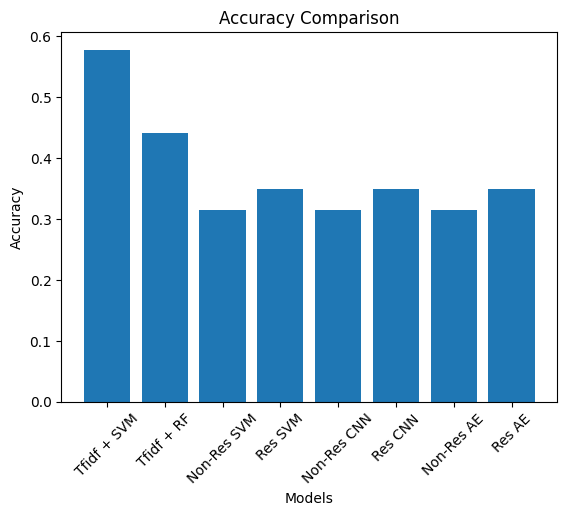

In [148]:
import matplotlib.pyplot as plt

labels = ['Tfidf + SVM', 'Tfidf + RF', 'Non-Res SVM', 'Res SVM', 'Non-Res CNN', 'Res CNN', 'Non-Res AE', 'Res AE']
values = [tf_svm_test_accuracy, tf_rf_test_accuracy, non_res_svm_accuracy, res_svm_accuracy, non_res_cnn_accuracy[1], res_cnn_accuracy[1], non_res_ae_accuracy, res_ae_accuracy]

plt.bar(labels, values)

plt.xticks(rotation=45)
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.show()